# GWP 3

## Step 2

We first download the exact returns data which was used in GWP2 to have a "training" dataset.

C:\Users\adevr\AppData\Local\Temp\ipykernel_16488\3177327235.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_train = yf.download(tickers, start=train_start_date, end=train_end_date)['Close']
[*********************100%***********************]  8 of 8 completed


Training Set Returns:
Ticker          AAPL      AMZN     GOOGL      META      MSFT      NFLX  \
Date                                                                     
2024-03-04 -0.025381 -0.003591 -0.027636 -0.008182 -0.001396 -0.005667   
2024-03-05 -0.028441 -0.019484 -0.005099 -0.015998 -0.029572 -0.028141   
2024-03-06 -0.005878 -0.003503 -0.009573  0.011974 -0.001391 -0.001353   
2024-03-07 -0.000709  0.019077  0.022679  0.032454  0.017533  0.018103   
2024-03-08  0.010237 -0.008314  0.007665 -0.012183 -0.007137 -0.006064   
...              ...       ...       ...       ...       ...       ...   
2024-11-11 -0.012029 -0.006437  0.011214 -0.010470 -0.010721  0.013081   
2024-11-12  0.000000  0.010008  0.007042  0.002829  0.012009  0.017456   
2024-11-13  0.003969  0.024843 -0.015086 -0.008242  0.005130  0.013386   
2024-11-14  0.013771 -0.012237 -0.018448 -0.004897  0.003975  0.008176   
2024-11-15 -0.014109 -0.041942 -0.017599 -0.039989 -0.027853 -0.015885   

Ticker         

<Axes: title={'center': 'Cumulative Returns of Training Set'}, xlabel='Date'>

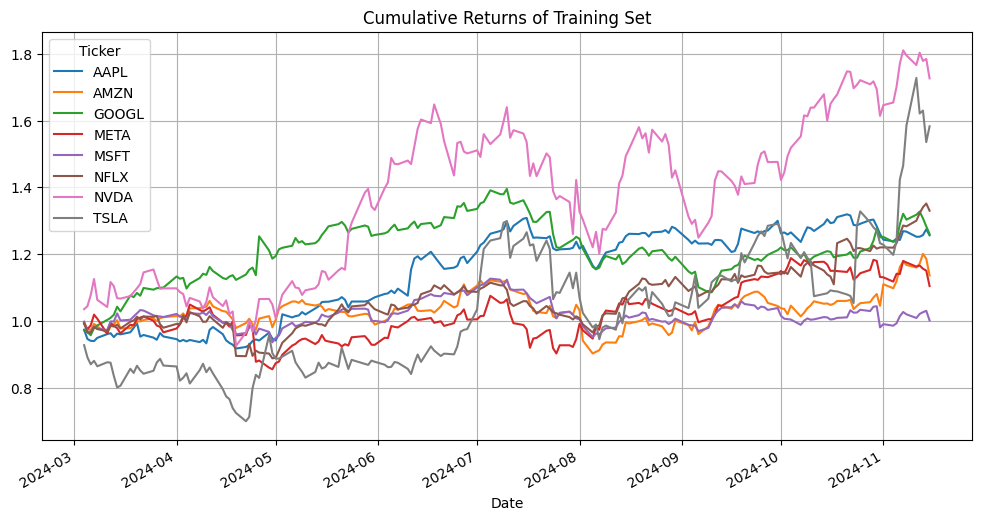

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

train_start_date = "2024-03-01"
dates = pd.date_range(start='2024-01-23', periods=300, freq='D')
train_end_date = dates[-1]
tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX']

prices_train = yf.download(tickers, start=train_start_date, end=train_end_date)['Close']
returns_train = prices_train.pct_change().dropna()
cum_returns_train = (1 + returns_train).cumprod()

print("Training Set Returns:")
print(returns_train)
cum_returns_train.plot(figsize=(12, 6), grid=True, title='Cumulative Returns of Training Set')

We then generate a "test" set, as mentioned on the GWP rubric.

In [175]:
test_start_date = train_end_date + pd.Timedelta(days=1)
test_end_date = "2025-08-20"

prices_test = yf.download(tickers, start=test_start_date, end=test_end_date)['Close']
returns_test = prices_test.pct_change().dropna()
returns_test

C:\Users\adevr\AppData\Local\Temp\ipykernel_16488\1293130021.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_test = yf.download(tickers, start=test_start_date, end=test_end_date)['Close']
[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,
2024-11-19,0.001140,0.014427,0.016087,0.012067,0.004883,0.028652,0.048948,0.021432
2024-11-20,0.003154,-0.008455,-0.012014,0.007895,-0.005505,0.014380,-0.007618,-0.011474
2024-11-21,-0.002096,-0.022181,-0.047449,-0.004297,-0.004317,0.015421,0.005347,-0.006988
2024-11-22,0.005908,-0.006351,-0.017121,-0.007015,0.010003,0.000345,-0.032181,0.038040
2024-11-25,0.013051,0.021966,0.017541,0.010677,0.004293,-0.035866,-0.041775,-0.039624
...,...,...,...,...,...,...,...,...
2025-08-13,0.016024,0.013952,-0.006787,-0.012557,-0.016363,-0.017008,-0.008572,-0.004284
2025-08-14,-0.002357,0.028589,0.004852,0.002628,0.003650,0.021687,0.002368,-0.011197
2025-08-15,-0.005112,0.000216,0.004730,0.003964,-0.004421,0.006818,-0.008625,-0.014959


The best performing portfolio in terms of reward/risk was the **Kelly Portfolio** in GWP2, which was the solution to the following optimization problem:

$max_f \quad (r + f^T (\mu - \large\mathbb{1} \normalsize r) - \large\frac{f^T \Sigma f}{2}) $

with constraints

$0 \le f_i \le 1 \qquad \text{for any} \quad 1\le i\le k$

$\Sigma_i^k f_i = 1 \qquad \text{for all} \quad 1\le i\le k$

Thus, we generate the optimal Kelly Portfolio again and save it as the *Vanilla Kelly Portfolio*, which will be compared to the other portfolios after the improvements are made: denoising, clustering and backtesting.

In [176]:
from scipy.optimize import minimize
r = 4.36 / 100 / 252  # we take the latest SOFR rate as our yearly risk-free rate, converted to daily return
mu = returns_train.mean(axis=0)
Sigma = returns_train.cov()
k = returns_train.shape[1]
ones_vector = np.ones(k)

# Define the objective function to be minimized
def g(f):
  col_f = f[:, np.newaxis]
  return -(r + np.dot(f, (mu - ones_vector*r)) - 0.5 * (col_f.T @ Sigma @ col_f))

# Assign initial value for f
f_init = np.array([1/k for asset in range(k)])

# Assign the constraint and bound
cons = ({'type': 'ineq', 'fun': lambda x:  1 - x.sum()})
bnds = tuple((0, 1) for f_i in f_init)

# Optimize
res = minimize(g, f_init, constraints=cons, bounds=bnds, tol=1e-12)
f_star = np.round(res.x, 4)
print("Optimal allocations vector:")
print(f_star)

Optimal allocations vector:
[0.     0.     0.     0.     0.     0.     0.7283 0.2717]


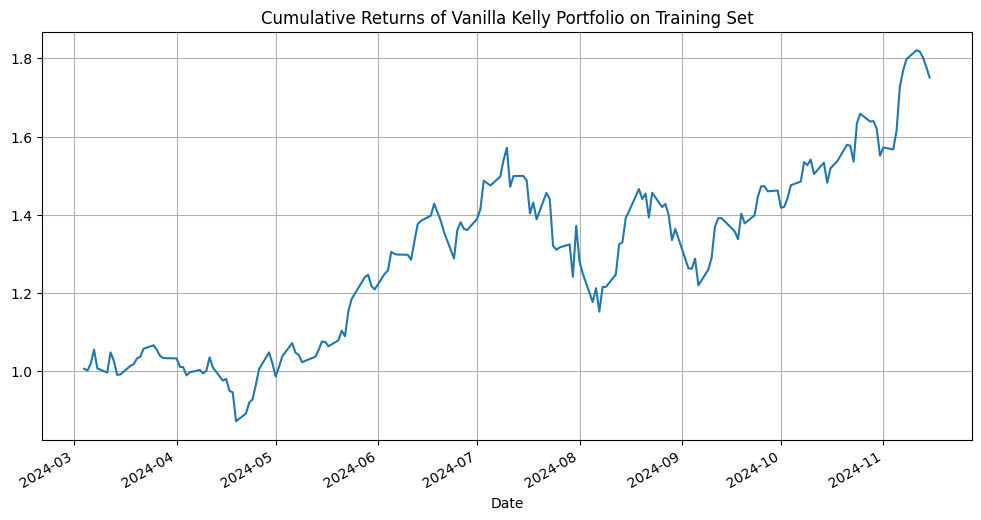

In [177]:
vanilla_kelly_portfolio_returns = (returns_train @ f_star[:, np.newaxis]).squeeze()
vanilla_kelly_portfolio_cum_returns = (1 + vanilla_kelly_portfolio_returns).cumprod()
vanilla_kelly_portfolio_cum_returns.plot(figsize=(12, 6), grid=True, title='Cumulative Returns of Vanilla Kelly Portfolio on Training Set')
plt.show()


Now, we generate the Kelly Portfolio with the same logic but in addition, we use portfolio optimization improvement techniques: denoising, clustering and backtesting.

### Denoising

We take the $(8 \times 8)$ correlation matrix $\Omega$ and apply eigendecomposition to it:

$\Omega = P D P^{-1}$

where,

$\Omega:$ Correlation matrix of the assets

$P:$ Principal components matrix (columns are the principal components)

$D:$ Diagonal matrix of eigenvalues

In [178]:
np.set_printoptions(precision=4, suppress=True)

excess_returns_train = returns_train - r * ones_vector  # Excess returns matrix

Sigma = returns_train.cov()  # Covariance matrix
Omega = returns_train.corr()  # Correlation matrix
sigma = np.sqrt(np.diag(Sigma)) * np.eye(k)  # Diagonal volatilities matrix

print("sigma (volatilities matrix):")
print(sigma)
print()

eigvals, eigM = np.linalg.eigh(Omega)

print("Eigenvalues of the correlation matrix:")
print(np.round(eigvals[::-1], 6))
print()

P = eigM[:, ::-1]  # Eigenvectors matrix, columns flipped for descending eigenvalues
D = (eigvals[::-1] * np.eye(k))  # Diagonal matrix of eigenvalues, sorted in descending order
s = excess_returns_train.mean(axis=0)  # Mean excess returns vector

# If a column in P has all negative values, we flip it to ensure positive eigenvectors
# because any scalar multiple of an eigenvector is also an eigenvector

for j in range(P.shape[1]):
    if np.max(P[:, j]) < 0:
        P[:, j] = -P[:, j]

print("Eigenvectors matrix:")
print(P)
print()

print("Reconstructed correlation matrix:")
print((P @ D @ P.T))

sigma (volatilities matrix):
[[0.0154 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0176 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0168 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0201 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.013  0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0181 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0343 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0424]]

Eigenvalues of the correlation matrix:
[3.8166 0.9643 0.786  0.6746 0.5365 0.4976 0.4399 0.2845]

Eigenvectors matrix:
[[ 0.3017 -0.4755 -0.126  -0.7581 -0.1343  0.1031  0.0887 -0.236 ]
 [ 0.4036  0.1052 -0.1523  0.2662  0.2107 -0.1976  0.689  -0.4168]
 [ 0.3697  0.0931 -0.3952  0.1742  0.3275  0.6471 -0.3625 -0.1034]
 [ 0.3672  0.3877 -0.1688 -0.0359 -0.3884 -0.4762 -0.4817 -0.2747]
 [ 0.4329  0.1336 -0.2287 -0.0899 -0.1189 -0.0675  0.2212  0.8165]
 [ 0.3412  0.0575  0.5785 -0.1911  0.6352 -

Thus, we get an eigenvectors matrix $P$ where column $j$ corresponds to the eigenvalue $j$ inside the eigenvalues vector $D$. We can think of the eigenvectors as asset weights and thus, because we have $8$ columns, we can construct $8$ **eigenportfolios** which will be linearly independent from each other by construction. Moreover, these eigenportfolios will have descending risk: 1st eigenportfolio will be the riskiest, while the 8th eigenportfolio will be the least risky portfolio.

In [179]:
R = excess_returns_train  # Excess returns matrix
theta = 0.75  # shrinkage parameter
D_shrunk = (1-theta) * D + theta * np.eye(k)  # Shrunk diagonal matrix of eigenvalues of Omega
Omega_shrunk = P @ D_shrunk @ P.T  # Shrunk correlation matrix
Sigma_shrunk = sigma @ Omega_shrunk @ sigma  # Shrunk covariance matrix
print("Shrunk covariance matrix:")
print(Sigma_shrunk)

Shrunk covariance matrix:
[[0.0002 0.     0.     0.     0.     0.     0.     0.0001]
 [0.     0.0003 0.     0.     0.     0.     0.0001 0.0001]
 [0.     0.     0.0003 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0004 0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.0002 0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.     0.0003 0.0001 0.    ]
 [0.     0.0001 0.     0.0001 0.0001 0.0001 0.0012 0.0001]
 [0.0001 0.0001 0.     0.     0.     0.     0.0001 0.0018]]


Then, we simply apply the same optimization process again but this time with our shrunk covariance matrix:

In [182]:
# Define the objective function to be minimized
gamma = 1  # risk aversion parameter, between 1 and 10
s = mu - r * ones_vector  # Mean excess returns vector

def g(theta):
  D_shrunk = (1-theta) * D + theta * np.eye(k)  # Shrunk diagonal matrix of eigenvalues of Omega
  Omega_shrunk = P @ D_shrunk @ P.T  # Shrunk correlation matrix
  Sigma_shrunk = sigma @ Omega_shrunk @ sigma  # Shrunk covariance matrix
  w = (1/gamma * np.linalg.inv(Sigma_shrunk) @ s[:, np.newaxis]).squeeze()  # Optimal weights vector
  portfolio_returns = (returns_train.to_numpy() @ w[:, np.newaxis]).squeeze() + (1 - w.sum()) * r  # Portfolio returns
  portfolio_sharpe = (portfolio_returns.mean() - r) / portfolio_returns.std()  # Portfolio Sharpe ratio
  return -portfolio_sharpe

# Assign initial value for f
theta_init = 0.5

# Assign the constraint and bound
bnds = [(0, 1)]  # Bounds for the shrinkage parameter

# Optimize
res = minimize(g, theta_init, constraints=None, bounds=bnds, tol=1e-12)
theta = res.x
w = (1/gamma * np.linalg.inv(Sigma_shrunk) @ s[:, np.newaxis]).squeeze()  # Optimal weights vector
print("Optimal shrinkage parameter:")
print(theta)
print("Optimal weights vector:")
print(w)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

Vanilla Kelly Portfolio Sharpe Ratio on Training Set: 1.7919
Shrunk Kelly Portfolio Sharpe Ratio on Training Set: 1.8013


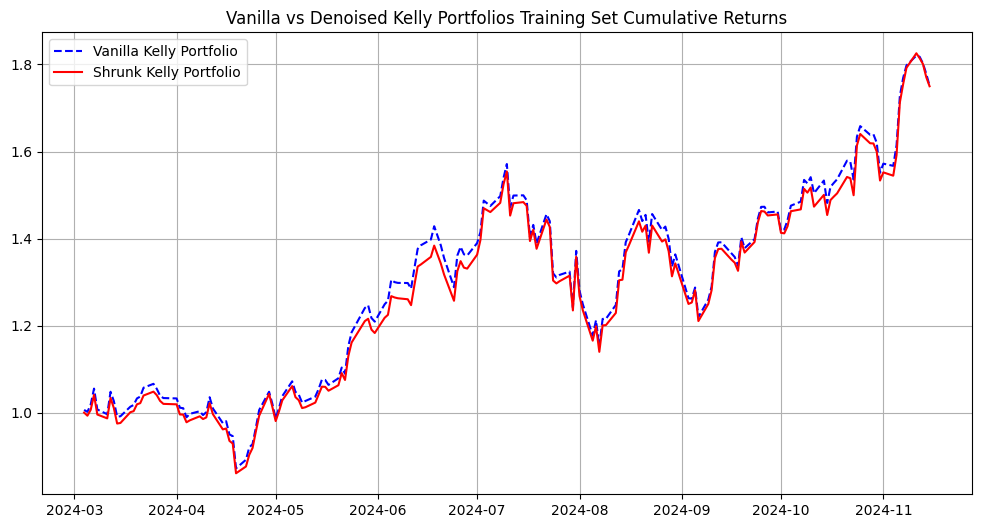

In [ ]:
shrunk_kelly_portfolio_returns = (returns_train @ f_star_shrunk[:, np.newaxis]).squeeze()
shrunk_kelly_portfolio_cum_returns = (1 + shrunk_kelly_portfolio_returns).cumprod()

vanilla_kelly_sharpe_train = (vanilla_kelly_portfolio_returns.mean() - r) / vanilla_kelly_portfolio_returns.std() * np.sqrt(252)
shrunk_kelly_sharpe_train = ((shrunk_kelly_portfolio_returns.mean() - r) / shrunk_kelly_portfolio_returns.std()) * np.sqrt(252)

print(f"Vanilla Kelly Portfolio Sharpe Ratio on Training Set: {vanilla_kelly_sharpe_train:.4f}")
print(f"Shrunk Kelly Portfolio Sharpe Ratio on Training Set: {shrunk_kelly_sharpe_train:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(vanilla_kelly_portfolio_cum_returns, label='Vanilla Kelly Portfolio', color='blue', linestyle='--')
plt.plot(shrunk_kelly_portfolio_cum_returns, label='Shrunk Kelly Portfolio', color='red')
plt.title("Vanilla vs Denoised Kelly Portfolios Training Set Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

Vanilla Kelly Portfolio Sharpe Ratio on Test Set: 0.6559
Shrunk Kelly Portfolio Sharpe Ratio on Test Set: 0.6256


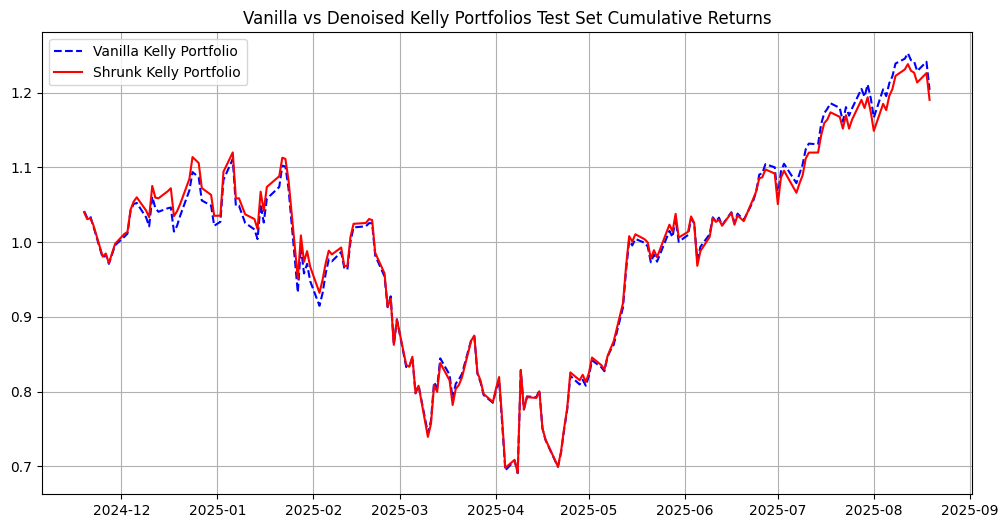

In [ ]:
vanilla_kelly_portfolio_returns_test = (returns_test @ f_star[:, np.newaxis]).squeeze()
vanilla_kelly_portfolio_cum_returns_test = (1 + vanilla_kelly_portfolio_returns_test).cumprod()

shrunk_kelly_portfolio_returns_test = (returns_test @ f_star_shrunk[:, np.newaxis]).squeeze()
shrunk_kelly_portfolio_cum_returns_test = (1 + shrunk_kelly_portfolio_returns_test).cumprod()

vanilla_kelly_sharpe_test = (vanilla_kelly_portfolio_returns_test.mean() - r) / vanilla_kelly_portfolio_returns_test.std() * np.sqrt(252)
shrunk_kelly_sharpe_test = ((shrunk_kelly_portfolio_returns_test.mean() - r) / shrunk_kelly_portfolio_returns_test.std()) * np.sqrt(252)

print(f"Vanilla Kelly Portfolio Sharpe Ratio on Test Set: {vanilla_kelly_sharpe_test:.4f}")
print(f"Shrunk Kelly Portfolio Sharpe Ratio on Test Set: {shrunk_kelly_sharpe_test:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(vanilla_kelly_portfolio_cum_returns_test, label='Vanilla Kelly Portfolio', color='blue', linestyle='--')
plt.plot(shrunk_kelly_portfolio_cum_returns_test, label='Shrunk Kelly Portfolio', color='red')
plt.title("Vanilla vs Denoised Kelly Portfolios Test Set Cumulative Returns")
plt.legend()
plt.grid()
plt.show()